In [1]:
# Standard Libraries
import os
import zipfile
from glob import glob
import random

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing Libraries
import cv2

# Machine Learning Libraries
import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split

**Define Parameters**

In [2]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Seed random
SEED = 42
random.seed(SEED)

# Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# **Step 1: Load Data**

In [3]:
def extract_data(zip_path, extracted_path):
    '''
    Extracts the ZIP file of the dataset.
    '''
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract ChestX-ray14 dataset
# TODO: Uncomment to extract data from zip
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [4]:
def load_labels(csv_path, extracted_path):
    '''
    Read labels from CSV, maps images to paths, and create binary disease labels.
    '''

    # Read the CSV containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create binary column for 'No Finding'
    labels_df['No Finding'] = labels_df['Finding Labels'].str.contains('No Finding').astype(int)

    # Map images to their full path
    labels_df['Path'] = labels_df['Image Index'].map(
        {os.path.basename(path): path for path in glob(os.path.join(extracted_path, '**', 'images', '*.png'))}
    )
    
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Print Dataframe**

In [5]:
df.head(5)

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x  ...  Fibrosis  Effusion  Pneumonia  \
0                        0.143  ...         0         0          0   
1                        0.143  ...         0         0          0   
2                        0.168  ...         0         1          0   
3                        0.171  ...         0         0          0   
4                        0.143  ...         0         0          0   

   Pleural_Thickening  Cardiomegaly  Nodule  Mass  Hernia  No Finding  \
0                   0             1       0     0       0           0   
1                   0             1       0     0       0           0   
2                   0             1       0     0       0           0   
3                   0             0       0     0       0           1   
4                   0             0       0     0       1           0   

                                                Path  
0  /cluster/home/bjorneme/projects/Data/chestX-ra...  
1  /cluster/home/bjorneme/projects/Data/chestX-ra...  
2  /cluster/home/bjorneme/projects/Data/chestX-ra...  
3  /cluster/home/bjorneme/projects/Data/chestX-ra...  
4  /cluster/home/bjorneme/projects/Data/chestX-ra...  

[5 rows x 28 columns]

**Split Dataset**

In [6]:
# Split based on patients
unique_patients = df['Patient ID'].unique()

# Split patients into training, validation and test sets
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.125, random_state=SEED
)

# Create dataframes for training, validation, and test sets
train_df = df[df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = df[df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = df[df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train dataset size: {len(train_df)}. Number of unique patients: {len(train_patients)}")
print(f"Validation size: {len(val_df)}. Number of unique patients: {len(val_patients)}")
print(f"Test size: {len(test_df)}. Number of unique patients: {len(test_patients)}")

Train dataset size: 78614. Number of unique patients: 21563
Validation size: 11212. Number of unique patients: 3081
Test size: 22294. Number of unique patients: 6161


# **Step 3: Exploratory Data Analysis (EDA)**

**Number of Unique Patients**

In [7]:
unique_patients = df['Patient ID'].nunique()
print(f'Number of patients: {unique_patients}')

Number of patients: 30805


**Distribution of Disease Label with No Finiding**

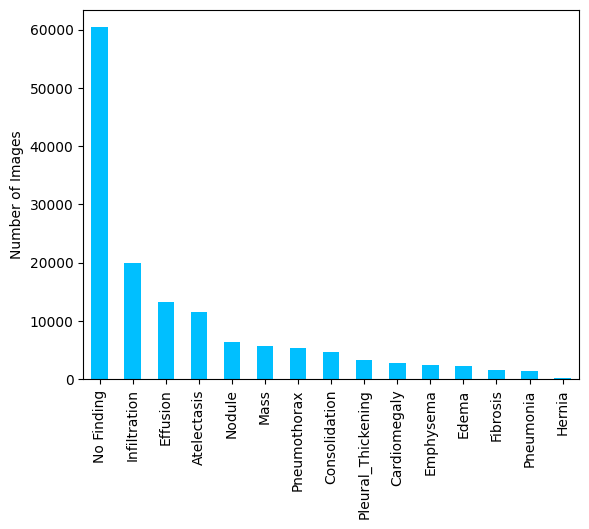

In [8]:
# Retrive labels from dataframe
labels_df = df[disease_labels + ['No Finding']]

# Count each label
counted_labels_df = labels_df.sum()

# Sort labels
counted_labels_df = counted_labels_df.sort_values(ascending=False)

# Plott counted_labels
plt.figure()
counted_labels_df.plot(kind='bar', color='deepskyblue')
plt.ylabel('Number of Images')
plt.show()

**Distribution of Disease Label with No Finiding (Train, Val and Test)**

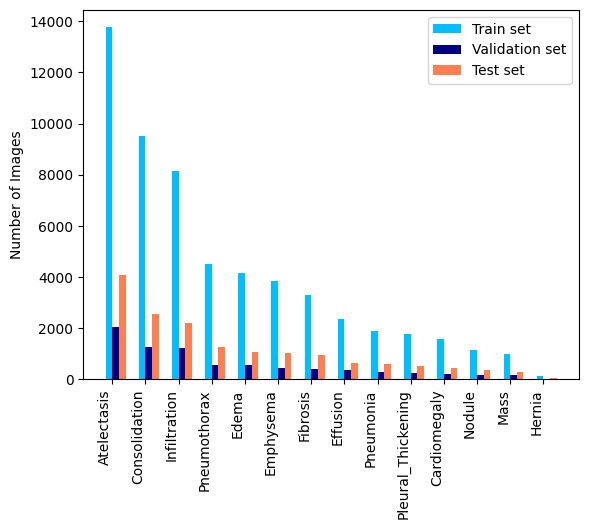

In [9]:
# Retrive labels from dataframe
labels_train_df = train_df[disease_labels]
labels_val_df = val_df[disease_labels]
labels_test_df = test_df[disease_labels]

# Count each label
counted_labels_train_df = labels_train_df.sum()
counted_labels_val_df = labels_val_df.sum()
counted_labels_test_df = labels_test_df.sum()

# Sort labels
counted_labels_train_df = counted_labels_train_df.sort_values(ascending=False)
counted_labels_val_df = counted_labels_val_df.sort_values(ascending=False)
counted_labels_test_df = counted_labels_test_df.sort_values(ascending=False)

# Bar width and indexes
bar_width = 0.2
indexes = np.arange(len(disease_labels))

# Plott counted_labels
plt.figure()
bars1 = plt.bar(indexes, counted_labels_train_df, bar_width, label='Train set', color='deepskyblue')
bars2 = plt.bar(indexes + bar_width, counted_labels_val_df, bar_width, label='Validation set', color='navy')
bars3 = plt.bar(indexes + 2*bar_width, counted_labels_test_df, bar_width, label='Test set', color='#FF7F50')

plt.xticks(indexes + bar_width / 2, disease_labels, rotation=90, ha='right')
plt.ylabel('Number of Images')
plt.legend()
plt.show()

**Distribution of Disease Label without No Finiding**

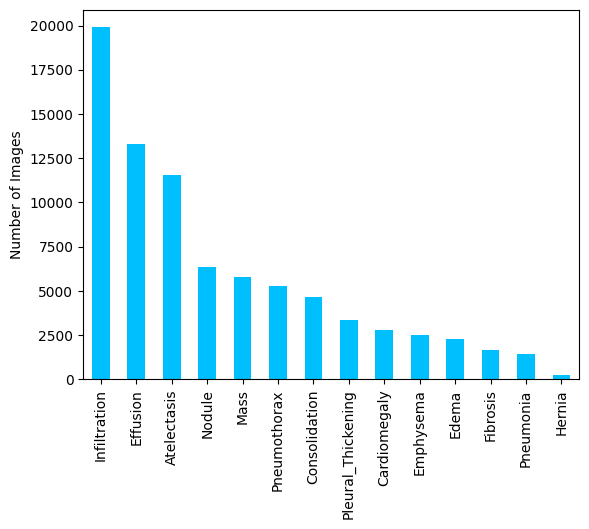

In [10]:
# Retrive labels from dataframe
labels_df = df[disease_labels]

# Count each label
counted_labels_df = labels_df.sum()

# Sort labels
counted_labels_df = counted_labels_df.sort_values(ascending=False)

# Plott counted_labels
plt.figure()
counted_labels_df.plot(kind='bar', color='deepskyblue')
plt.ylabel('Number of Images')
plt.show()

**Distribution of Patient Age**

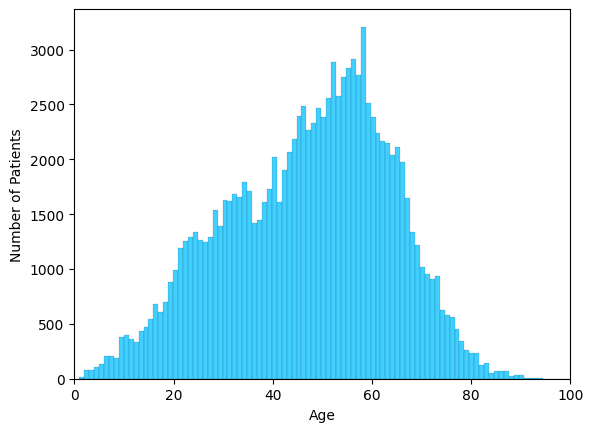

In [11]:
# Plot distribution of ages
plt.figure()
sns.histplot(df['Patient Age'], color='deepskyblue')
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.xlim(0, 100)
plt.show()

In [12]:
# Convert to number
patient_age_df = pd.to_numeric(df['Patient Age'], errors='coerce')

# Calculate % between 0 and 9 years old
percentage_under_10 = (patient_age_df < 10).sum() / len(df) * 100
print(f"Percentage of patients under 10 years old: {percentage_under_10:.1f}%")

# Calculate % over 80 years old
percentage_over_or_equal_to_80 = (patient_age_df >= 80).sum() / len(df) * 100
print(f"Percentage of patients over or equal to 80 years old: {percentage_over_or_equal_to_80:.1f}%")

Percentage of patients under 10 years old: 1.3%
Percentage of patients over or equal to 80 years old: 1.0%


**Distribution of Patient Gender**

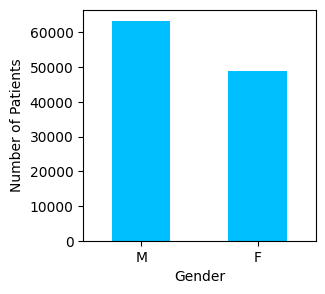

In [13]:
# Count number of each gender
gender_df = df['Patient Gender'].value_counts()

# Plot distribution of gender
plt.figure(figsize=(3, 3))
gender_df.plot(kind='bar', color='deepskyblue')
plt.xlabel('Gender')
plt.xticks(rotation=0)
plt.ylabel('Number of Patients')
plt.show()

In [14]:
# Calculate M vs. F %
M_percentage = (gender_df['M'] / gender_df.sum()) * 100
print(f"M: {M_percentage:.1f}%")

F_percentage = (gender_df['F'] / gender_df.sum()) * 100
print(f"F: {F_percentage:.1f}%")

M: 56.5%
F: 43.5%


**Distribution of Patient View Position**

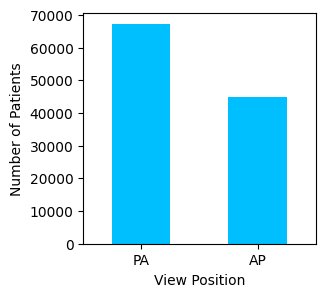

In [15]:
# Count number of each view position
view_position_df = df['View Position'].value_counts()

# Plot distribution of view positions
plt.figure(figsize=(3, 3))
view_position_df.plot(kind='bar', color='deepskyblue')
plt.xlabel('View Position')
plt.xticks(rotation=0)
plt.ylabel('Number of Patients')
plt.show()


In [16]:
# Calculate PA vs. AP in %
PA_percentage = (view_position_df['PA'] / view_position_df.sum()) * 100
print(f"PA: {PA_percentage:.1f}%")

AP_percentage = (view_position_df['AP'] / view_position_df.sum()) * 100
print(f"AP: {AP_percentage:.1f}%")

PA: 60.0%
AP: 40.0%


**Distribution of Images per Patient**

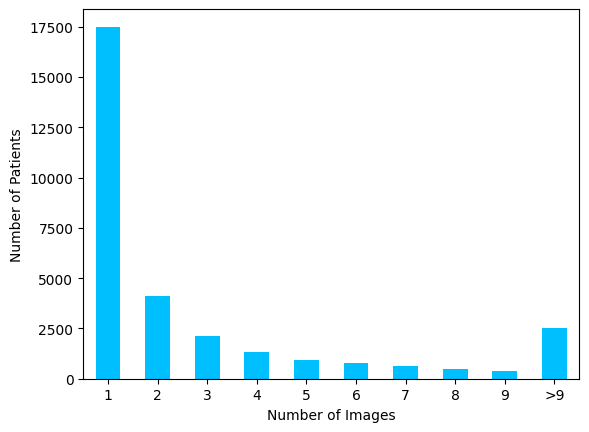

In [17]:
# Count number of images per patient
images_per_patient_df = df.groupby('Patient ID').size()

# Group all occurences of >9, the rest keeps its index
images_per_patient_df_with_bins = images_per_patient_df.apply(lambda x: '>9' if x > 9 else str(x))
  
# Count occurrences of each number of images and sort by index
images_per_patient_df_with_bins = images_per_patient_df_with_bins.value_counts().sort_index()

# Plot the distribution
plt.figure()
images_per_patient_df_with_bins.plot(kind='bar', color='deepskyblue')
plt.xlabel('Number of Images')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.show()

In [18]:
# Calculate % of patients with over >9 images
over_9_percentage = (images_per_patient_df_with_bins['>9'] / images_per_patient_df_with_bins.sum()) * 100
print(f">9 images: {over_9_percentage:.1f}%")

# Find the max number of images for a patient
print(f"Highest number of images for a patient: {images_per_patient_df.max()}")

>9 images: 8.3%
Highest number of images for a patient: 184


**Distribution of Diseases per Image**

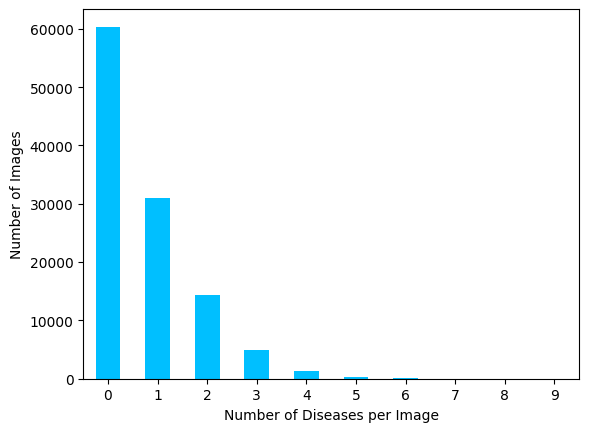

In [19]:
# Count number of diseases per image
df['Number of Diseases'] = df[disease_labels].sum(axis=1)

# Count occurrences of each number of diseases and sort by index
disease_count_distribution_df = df['Number of Diseases'].value_counts().sort_index()

# Plot the distribution
plt.figure()
disease_count_distribution_df.plot(kind='bar', color='deepskyblue')
plt.xlabel('Number of Diseases per Image')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.show()

In [20]:
# Convert to number
disease_count_distribution_df_numeric = pd.to_numeric(df['Number of Diseases'], errors='coerce')

# Calculate % of images with over one disease
over_one_disease = (disease_count_distribution_df_numeric > 1).sum() / len(df) * 100
print(f"Images with over one disease: {over_one_disease:.1f}%")

# Find number of images with 9 diseases
print(f"Images with 9 diseases: {disease_count_distribution_df[9]}")

Images with over one disease: 18.5%
Images with 9 diseases: 2


**Distribution of Co-occurrence of Labels**

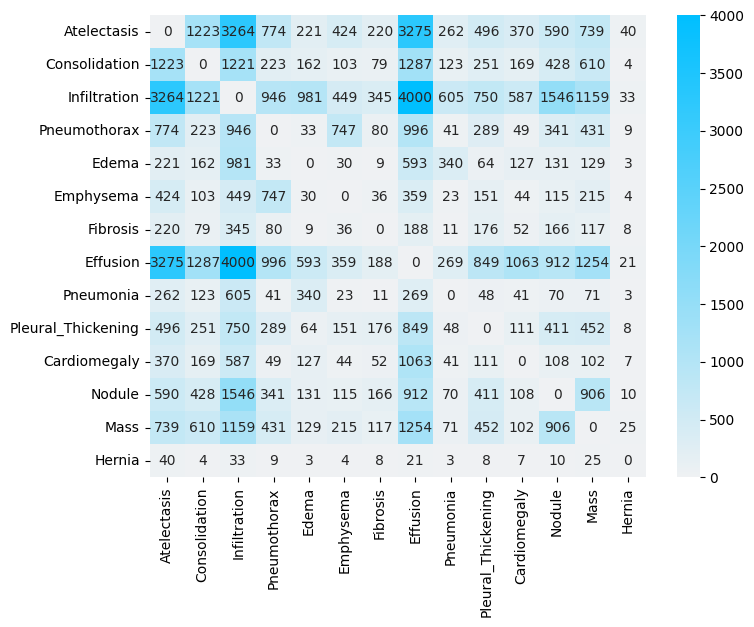

In [21]:
# Calculate co-occurrence
co_occurrence_df = df[disease_labels].T.dot(df[disease_labels])

# Remove the diagonal
for disease in disease_labels:
    co_occurrence_df.loc[disease, disease] = 0

# Create a skyblue colormap
custom_cmap = sns.light_palette('deepskyblue', as_cmap=True)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(co_occurrence_df, annot=True, fmt='.0f', cmap=custom_cmap)
plt.show()

**Distribution of Image Resolutions**

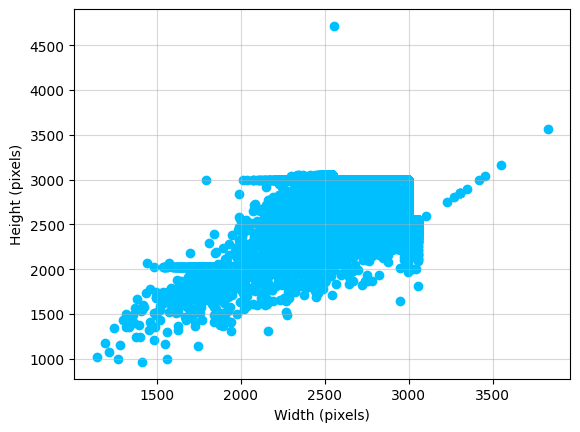

In [22]:
# Extract height and width
widths = df['OriginalImage[Width']
heights = df['Height]']

# Create the scatter plot
plt.figure()
plt.scatter(widths, heights, color='deepskyblue')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(alpha=0.5)
plt.show()

In [23]:
# Create the dataframe with resolution statistic
resolution_summary = pd.DataFrame({
    " ": ["Mean", "Median", "Min", "Max", "Std"],
    "Width (pixels)": [
        widths.mean(),
        widths.median(),
        widths.min(),
        widths.max(),
        widths.std()
    ],
    "Height (pixels)": [
        heights.mean(),
        heights.median(),
        heights.min(),
        heights.max(),
        heights.std()
    ]
})

# Present the resolution statistic
resolution_summary.round(0)

Width (pixels)  Height (pixels)
0    Mean          2646.0           2486.0
1  Median          2518.0           2544.0
2     Min          1143.0            966.0
3     Max          3827.0           4715.0
4     Std           341.0            401.0

# **Step 4: Explore Data Augmentations**

**Select Images to Plot**

In [24]:
# Selected from all images
sampled_df = random.sample(df[['Path', 'Finding Labels']].values.tolist(), 9)

# Only selected from images with diseases present
df_with_diseases = df[df["No Finding"] == 0]

sampled_with_diseases_df = random.sample(df_with_diseases[['Path', 'Finding Labels']].values.tolist(), 9)

**Images without Augmentations**

In [25]:
transform = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224,224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
])

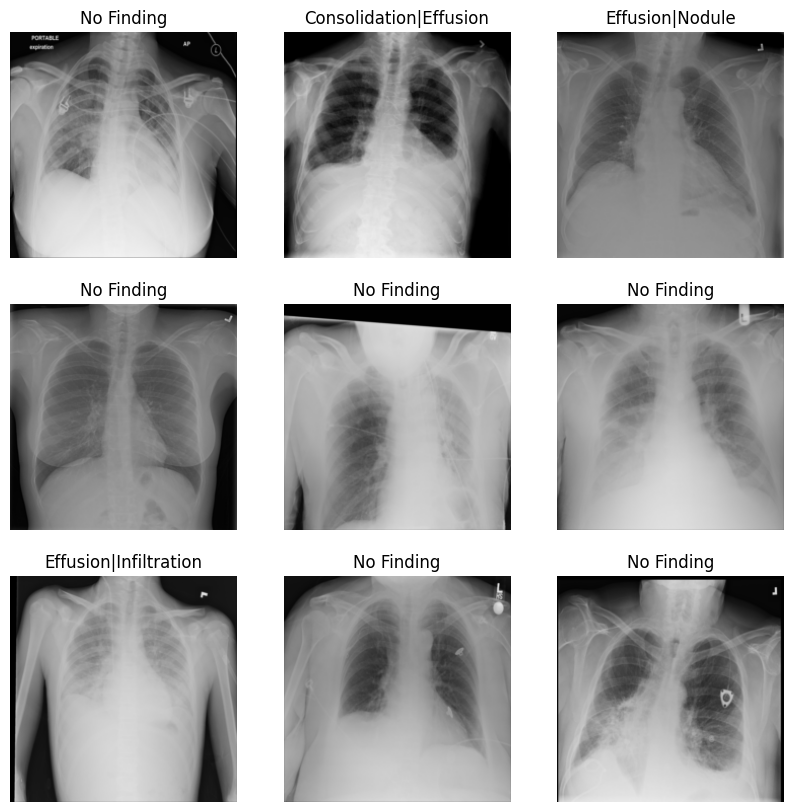

In [26]:
# Plot the samples
plt.figure(figsize=(10, 10))
for i, (img_path, finding_labels) in enumerate(sampled_df):
    image = plt.imread(img_path)

    plt.subplot(3, 3, i + 1)

    # Transform image
    image = transform(image)

    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(finding_labels)
    
plt.show()

**Images without Augmentations, but with Diseases Present**

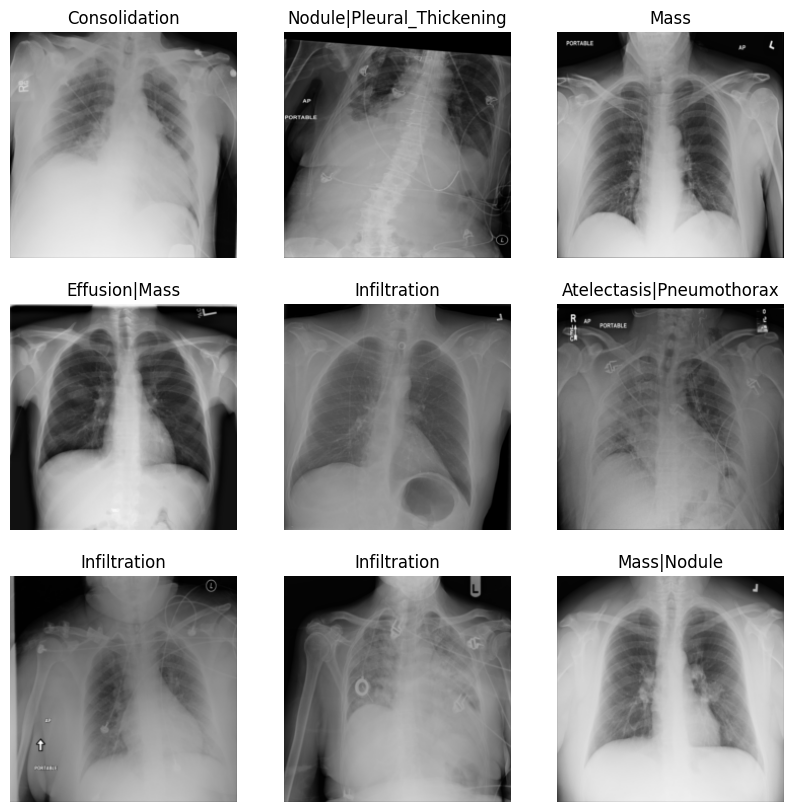

In [27]:
# Plot the samples
plt.figure(figsize=(10, 10))

for i, (img_path, finding_labels) in enumerate(sampled_with_diseases_df):
    image = plt.imread(img_path)

    plt.subplot(3, 3, i + 1)

    # Transform image
    image = transform(image)

    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(finding_labels)
    
plt.show()

**Random Cropping**

In [28]:
transform_crop = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 256x256
    transforms.Resize((256,256)),

    # Randomly resize the image
    transforms.RandomCrop((224,224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
])

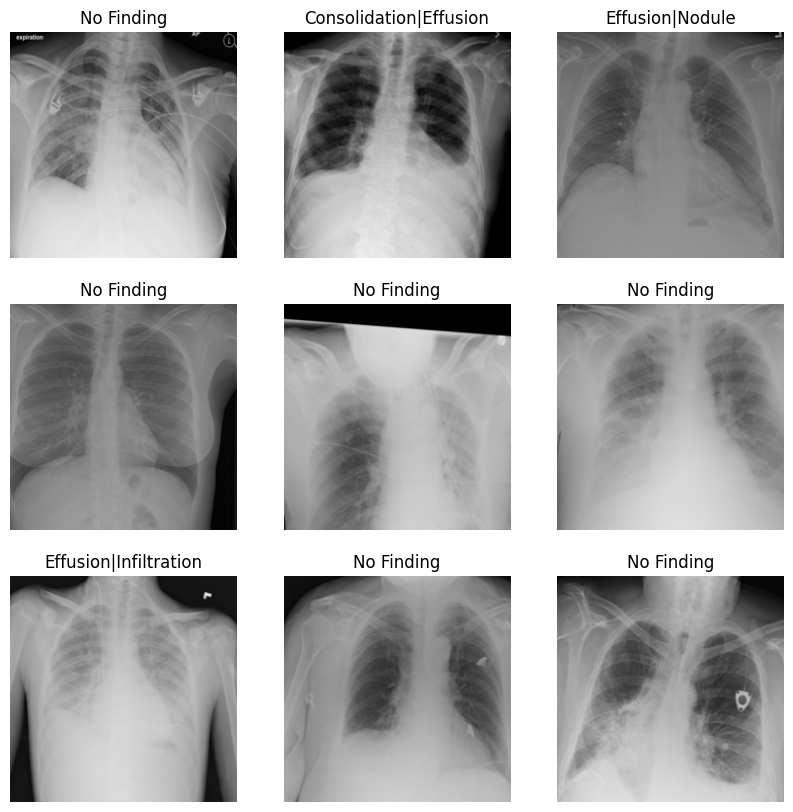

In [29]:
# Plot the samples
plt.figure(figsize=(10, 10))
for i, (img_path, finding_labels) in enumerate(sampled_df):
    image = plt.imread(img_path)

    plt.subplot(3, 3, i + 1)

    # Transform image
    image = transform_crop(image)

    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(finding_labels)
plt.show()

**Random Horizontal Flip**

In [30]:
transform_flip = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224,224)),

    # Apply random horizontal flip
    transforms.RandomHorizontalFlip(p=1),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
])

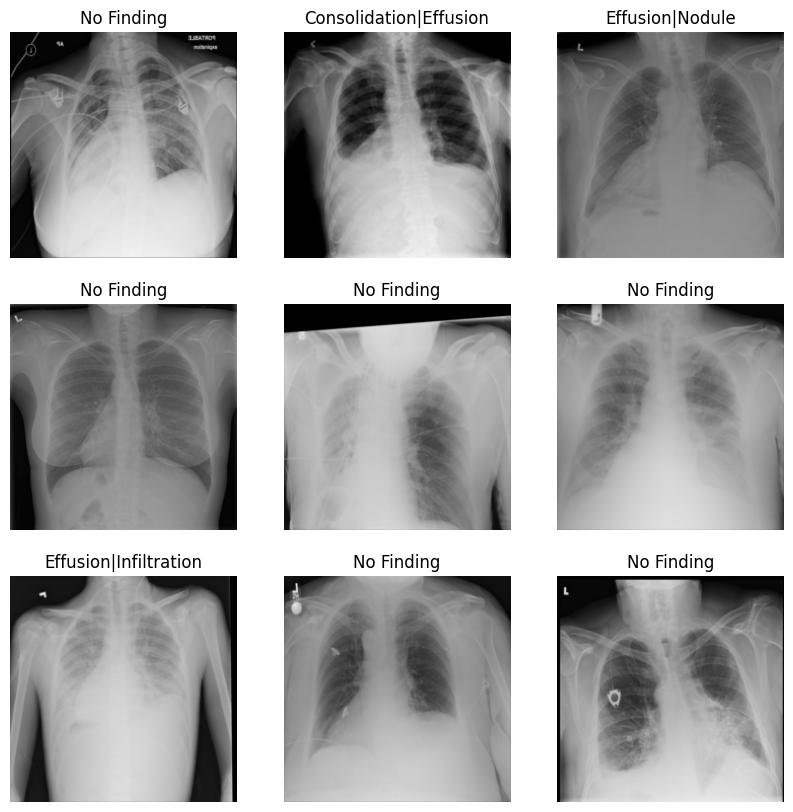

In [31]:
# Plot the samples
plt.figure(figsize=(10, 10))
for i, (img_path, finding_labels) in enumerate(sampled_df):
    image = plt.imread(img_path)

    plt.subplot(3, 3, i + 1)

    # Transform image
    image = transform_flip(image)

    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(finding_labels)
plt.show()

**Random Rotation**

In [32]:
transform_rotation = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224,224)),

    # Randomly rotate the image with ±10 degrees
    transforms.RandomRotation(10),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
])

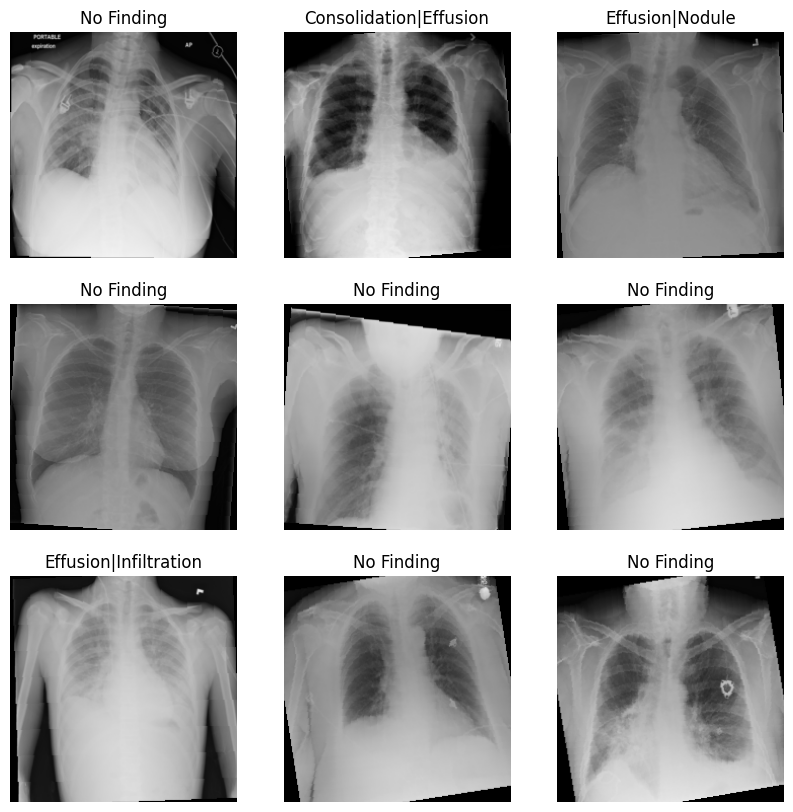

In [33]:
# Plot the samples
plt.figure(figsize=(10, 10))
for i, (img_path, finding_labels) in enumerate(sampled_df):
    image = plt.imread(img_path)

    plt.subplot(3, 3, i + 1)

    # Transform image
    image = transform_rotation(image)

    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(finding_labels)
plt.show()

**Random Brightness**

In [34]:
transform_brightness = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224,224)),

    # Apply random brightness
    transforms.ColorJitter(
        brightness=(0.8, 1.2),
    ),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
])

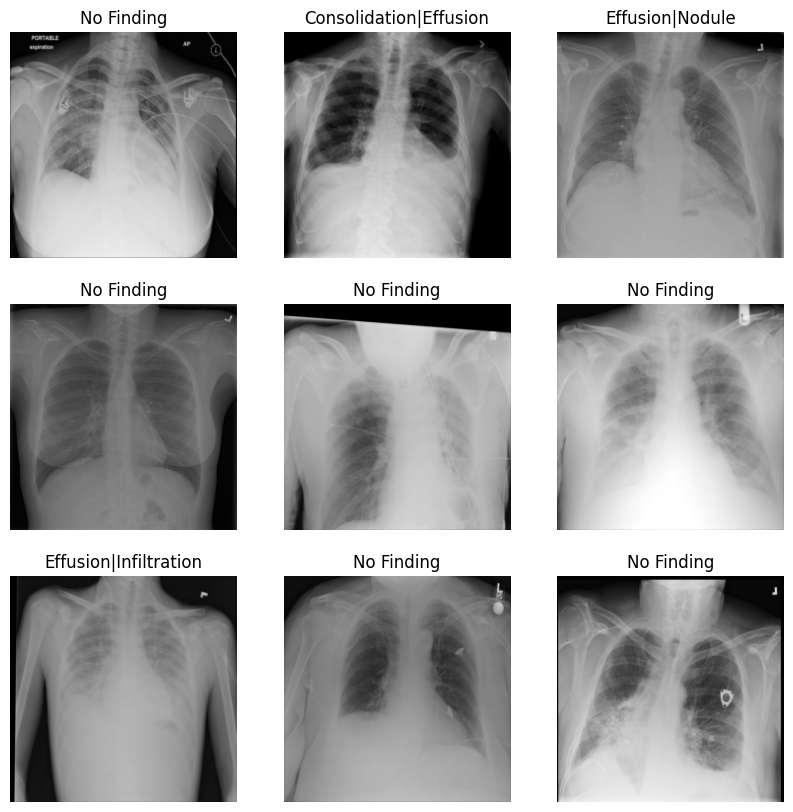

In [35]:
# Plot the samples
plt.figure(figsize=(10, 10))
for i, (img_path, finding_labels) in enumerate(sampled_df):
    image = plt.imread(img_path)

    plt.subplot(3, 3, i + 1)

    # Transform image
    image = transform_brightness(image)

    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(finding_labels)
plt.show()

**Random Contrast**

In [36]:
transform_contrast = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224,224)),

    # Apply random contrast
    transforms.ColorJitter(
        contrast=(0.8, 1.2)
    ),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
])

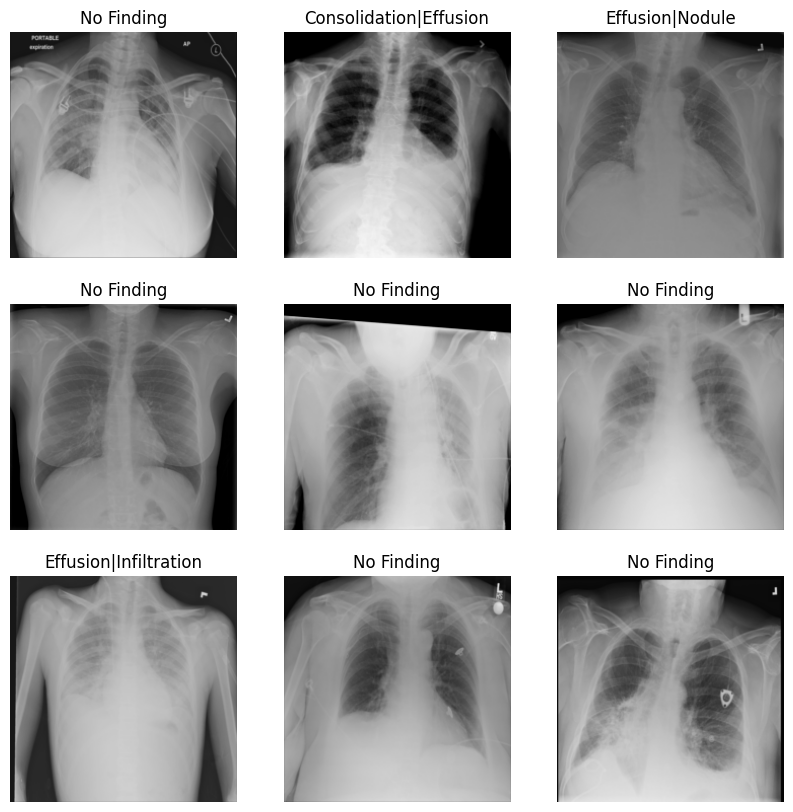

In [37]:
# Plot the samples
plt.figure(figsize=(10, 10))
for i, (img_path, finding_labels) in enumerate(sampled_df):
    image = plt.imread(img_path)

    plt.subplot(3, 3, i + 1)

    # Transform image
    image = transform_contrast(image)

    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(finding_labels)
plt.show()

**Random Erasing**

In [38]:
transform_erasing = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224,224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Random erasing of image
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1))
])

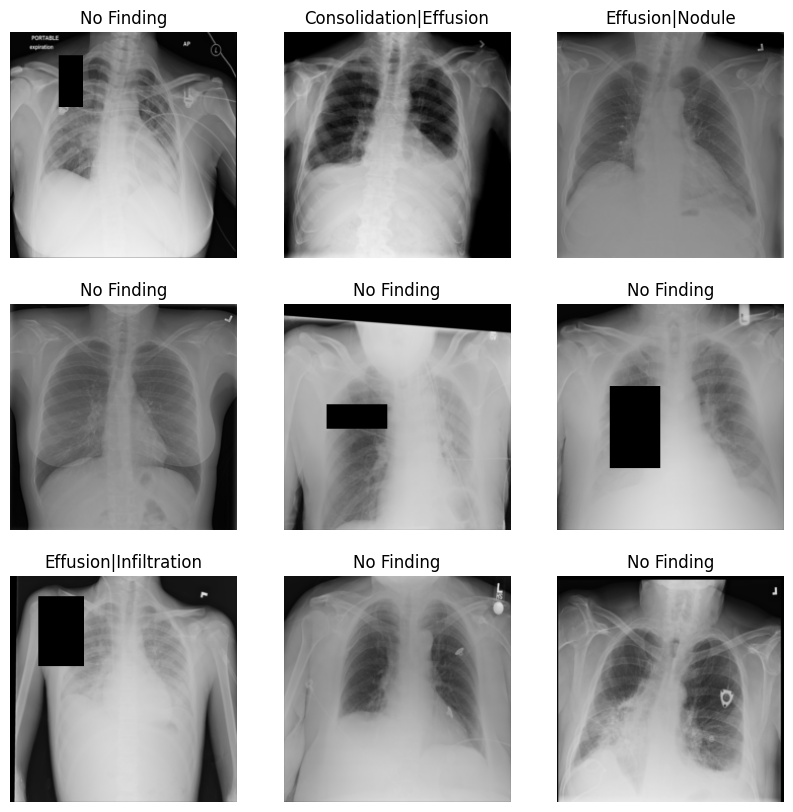

In [39]:
# Plot the samples
plt.figure(figsize=(10, 10))
for i, (img_path, finding_labels) in enumerate(sampled_df):
    image = plt.imread(img_path)

    plt.subplot(3, 3, i + 1)

    # Transform image
    image = transform_erasing(image)

    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(finding_labels)
plt.show()

**Random Gaussian Blur**

In [40]:
transform_gaussian_blur = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224,224)),

    # Apply random gaussian blur
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 0.5)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
])

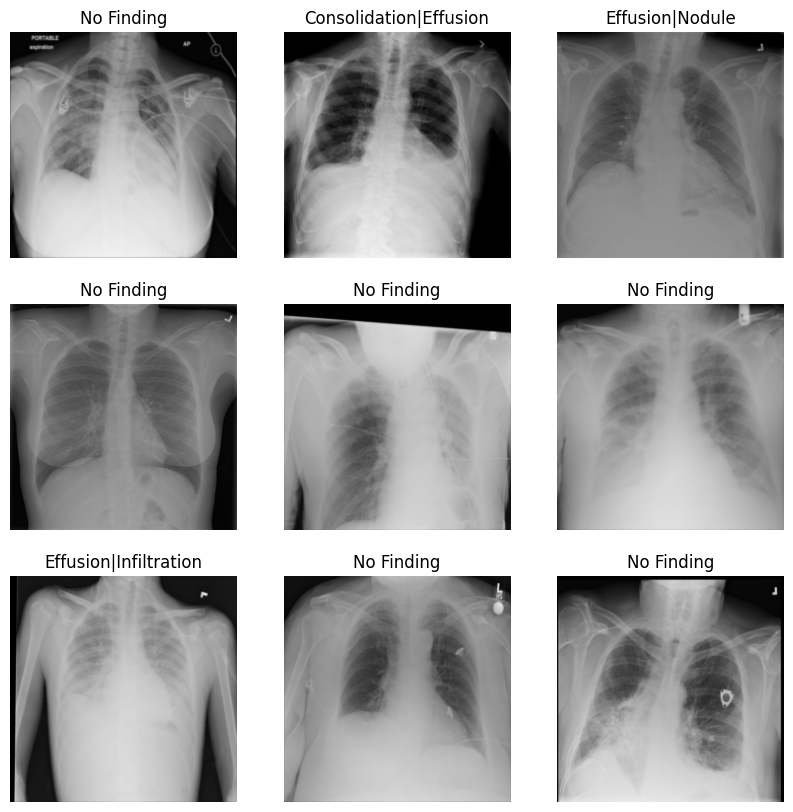

In [41]:
# Plot the samples
plt.figure(figsize=(10, 10))
for i, (img_path, finding_labels) in enumerate(sampled_df):
    image = plt.imread(img_path)

    plt.subplot(3, 3, i + 1)

    # Transform image
    image = transform_gaussian_blur(image)

    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(finding_labels)
plt.show()

**Combine All Augmentations**

In [42]:
transforms_list = [
    
    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 256x256
    transforms.Resize((256,256)),

    # Randomly 224x224 crops
    transforms.RandomCrop(224),

    # Apply random horizontal flip
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image with ±10 degrees
    transforms.RandomRotation(10),

    # Apply random brightness
    transforms.ColorJitter(
        brightness=(0.8, 1.2),
    ),

    # Apply random contrast
    transforms.ColorJitter(
        contrast=(0.8, 1.2),
    ),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Apply random erasing of image
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1)),

    # Apply random erasing of image
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1)),

    # Apply random erasing of image
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1))
]

# Apply GaussianBlur
if random.random() < 0.25:
    transforms_list.append( 
        transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 0.5))
    )

byol_transform = transforms.Compose(transforms_list)

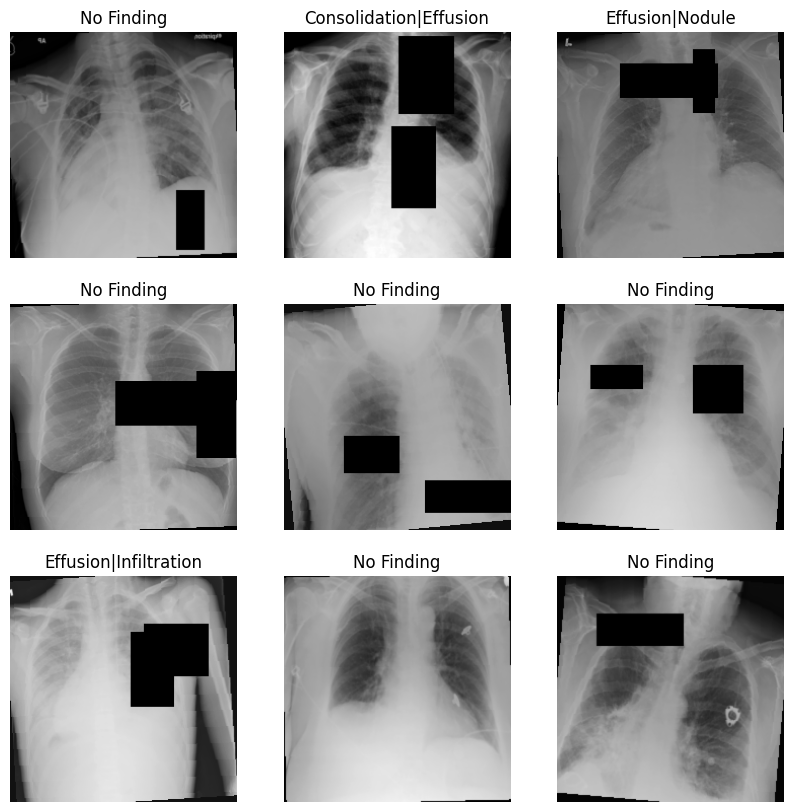

In [43]:
# Plot the samples
plt.figure(figsize=(10, 10))
for i, (img_path, finding_labels) in enumerate(sampled_df):
    image = plt.imread(img_path)

    plt.subplot(3, 3, i + 1)

    # Transform image
    image = byol_transform(image)

    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(finding_labels)
plt.show()